In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import random
import cv2
import os
import tensorflow as tf
from tqdm import tqdm
from google.colab import drive 


In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
good_frames = '/content/drive/MyDrive/idb/dataset/Sharp/xray'
blur_frames= '/content/drive/MyDrive/idb/gblur'

In [ ]:
src_dir= good_frames
images = os.listdir(src_dir)
dst_dir=blur_frames

In [ ]:
# for i, img in tqdm(enumerate(images), total=len(images)):
#     img = cv2.imread(f"{src_dir}/{images[i]}")
#     # add gaussian blurring
#     blur = cv2.GaussianBlur(img, (31, 31), 0)
#     cv2.imwrite(f"{dst_dir}/{images[i]}", blur)
# print('DONE')

100%|██████████| 400/400 [01:59<00:00,  3.34it/s]

DONE


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import cv2
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import argparse
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split

In [ ]:
clean_frames = []
for file in tqdm(sorted(os.listdir(good_frames))):
  if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
    image = tf.keras.preprocessing.image.load_img(good_frames + '/' + file, target_size=(224,224))
    image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
    clean_frames.append(image)

clean_frames = np.array(clean_frames)
blurry_frames = []
for file in tqdm(sorted(os.listdir(blur_frames))):
  if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
    image = tf.keras.preprocessing.image.load_img(blur_frames + '/' + file, target_size=(224,224))
    image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
    blurry_frames.append(image)

blurry_frames = np.array(blurry_frames)

100%|██████████| 400/400 [00:12<00:00, 31.72it/s]


In [ ]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.utils.vis_utils import plot_model
from keras import backend as K

seed = 21
random.seed = seed
np.random.seed = seed


In [10]:
x = clean_frames;
y = blurry_frames;
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [11]:
print(x_train[0].shape)
print(y_train[0].shape)

(224, 224, 3)
(224, 224, 3)


78


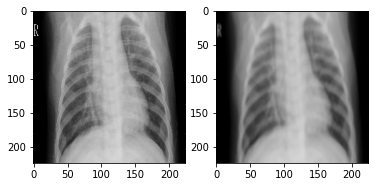

In [12]:
r = random.randint(0, len(clean_frames)-1)
print(r)
fig = plt.figure()
fig.subplots_adjust(hspace=0.1, wspace=0.2)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(clean_frames[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(blurry_frames[r])

340


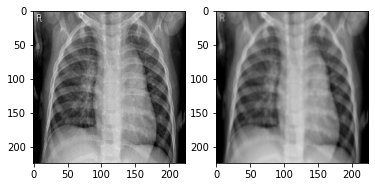

In [ ]:
r = random.randint(0, len(clean_frames)-1)
print(r)
fig = plt.figure()
fig.subplots_adjust(hspace=0.1, wspace=0.2)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(clean_frames[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(blurry_frames[r])

In [ ]:
# Network Parameters
input_shape = (224, 224, 3)
batch_size = 32
kernel_size = 2
latent_dim = 256

# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [128,64,128,64,32]

In [ ]:
inputs = Input(shape = input_shape, name = 'encoder_input')
x = inputs


In [ ]:
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)
shape = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [ ]:
encoder = Model(inputs, latent, name='encoder')
encoder.summary()


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 128)     1664      
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        32832     
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       32896     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        32832     
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 32)          8224      
                                                                 
 flatten (Flatten)           (None, 1568)              0   

In [ ]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

outputs = Conv2DTranspose(filters=5,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)


In [ ]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 1568)              402976    
                                                                 
 reshape (Reshape)           (None, 7, 7, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 32)       4128      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 64)       8256      
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 56, 56, 128)      3289

In [ ]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 224, 224, 3)]     0         
                                                                 
 encoder (Functional)        (None, 256)               510112    
                                                                 
 decoder (Functional)        (None, 224, 224, 3)       515523    
                                                                 
Total params: 1,025,635
Trainable params: 1,025,635
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Hyperparameters
autoencoder.compile(loss='mse', optimizer='adam',metrics=["acc"])

In [ ]:
#learning rate reducer to reduce the learning rate if there’s no 
#improvement in the metric

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

In [ ]:
callbacks = [lr_reducer]

In [ ]:
# history = autoencoder.fit(x_train,
#                       y_train,
#                       validation_data=(x_test, y_test),
#                       epochs=50,
#                       batch_size=batch_size,
#                       callbacks=callbacks)
#kernel =3
#Batch size=10
#layers=[32,64,128,256]

Epoch 1/50
32/32 [==============================] - 33s 1s/step - loss: 0.0065 - acc: 0.3301 - val_loss: 0.0070 - val_acc: 0.3323 - lr: 0.0010
Epoch 2/50
32/32 [==============================] - 35s 1s/step - loss: 0.0060 - acc: 0.3313 - val_loss: 0.0066 - val_acc: 0.3271 - lr: 0.0010
Epoch 3/50
32/32 [==============================] - 34s 1s/step - loss: 0.0056 - acc: 0.3308 - val_loss: 0.0066 - val_acc: 0.3266 - lr: 0.0010
Epoch 4/50
32/32 [==============================] - 33s 1s/step - loss: 0.0054 - acc: 0.3311 - val_loss: 0.0064 - val_acc: 0.3184 - lr: 0.0010
Epoch 5/50
32/32 [==============================] - 35s 1s/step - loss: 0.0051 - acc: 0.3309 - val_loss: 0.0059 - val_acc: 0.3250 - lr: 0.0010
Epoch 6/50
32/32 [==============================] - 33s 1s/step - loss: 0.0048 - acc: 0.3356 - val_loss: 0.0056 - val_acc: 0.3173 - lr: 0.0010
Epoch 7/50
32/32 [==============================] - 33s 1s/step - loss: 0.0046 - acc: 0.3355 - val_loss: 0.0059 - val_acc: 0.3092 - lr: 0.0010

In [ ]:
# history = autoencoder.fit(x_train,
#                       y_train,
#                       validation_data=(x_test, y_test),
#                       epochs=50,
#                       batch_size=batch_size,
#                       callbacks=callbacks)
# # Network Parameters
# input_shape = (224, 224, 3)
# batch_size = 32
# kernel_size = 2
# latent_dim = 256

# # Encoder/Decoder number of CNN layers and filters per layer
# layer_filters = [128,64,128,64,32]

Epoch 1/50
10/10 [==============================] - 86s 8s/step - loss: 0.0523 - acc: 0.5894 - val_loss: 0.0539 - val_acc: 0.3911 - lr: 0.0010
Epoch 2/50
10/10 [==============================] - 76s 8s/step - loss: 0.0522 - acc: 0.5042 - val_loss: 0.0541 - val_acc: 0.5434 - lr: 0.0010
Epoch 3/50
10/10 [==============================] - 87s 9s/step - loss: 0.0522 - acc: 0.2662 - val_loss: 0.0540 - val_acc: 0.0117 - lr: 0.0010
Epoch 4/50
10/10 [==============================] - 82s 8s/step - loss: 0.0521 - acc: 0.0265 - val_loss: 0.0539 - val_acc: 0.0677 - lr: 0.0010
Epoch 5/50
10/10 [==============================] - 80s 8s/step - loss: 0.0519 - acc: 0.1670 - val_loss: 0.0514 - val_acc: 0.3317 - lr: 0.0010
Epoch 6/50
10/10 [==============================] - 82s 8s/step - loss: 0.0399 - acc: 0.5553 - val_loss: 0.0324 - val_acc: 0.7819 - lr: 0.0010
Epoch 7/50
10/10 [==============================] - 82s 8s/step - loss: 0.0247 - acc: 0.4908 - val_loss: 0.0213 - val_acc: 0.1965 - lr: 0.0010

KeyboardInterrupt: ignored


       Input                        Ground Truth                  Predicted Value
1/1 [==============================] - 0s 81ms/step


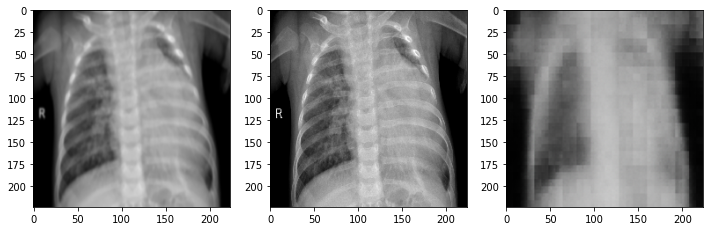

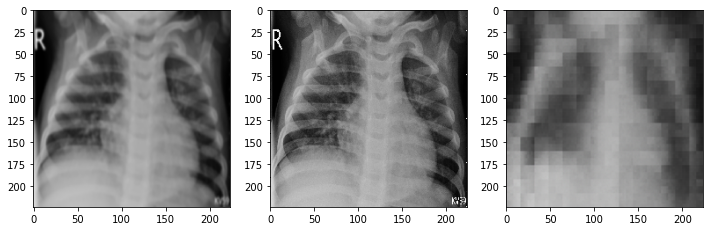

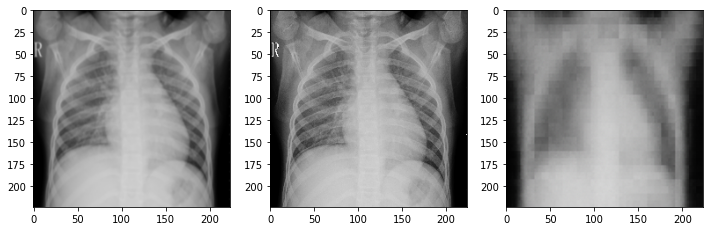

In [ ]:
print("\n       Input                        Ground Truth                  Predicted Value")
for i in range(3):
    
    r = random.randint(0, len(clean_frames)-1)

    x, y = blurry_frames[r],clean_frames[r]
    x_inp=x.reshape(1,224,224,3)
    result = autoencoder.predict(x_inp)
    result = result.reshape(224,224,3)

    fig = plt.figure(figsize=(12,10))
    fig.subplots_adjust(hspace=0.1, wspace=0.2)

    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x)

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(y)

    ax = fig.add_subplot(1, 3, 3)
    plt.imshow(result)

In [ ]:

autoencoder.save('/content/drive/MyDrive/idb/saved_model/DAE') 

In [ ]:
autoencoder.save('/content/drive/MyDrive/idb/DAE.h5') 

TAKE 5


In [ ]:
# Network Parameters
input_shape = (224, 224, 3)
batch_size = 10
kernel_size = 5
latent_dim = 256

# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [32,64,128,164,256]

inputs = Input(shape = input_shape, name = 'encoder_input')
x = inputs

for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)
shape = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

encoder = Model(inputs, latent, name='encoder')
encoder.summary()


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_51 (Conv2D)          (None, 112, 112, 32)      2432      
                                                                 
 conv2d_52 (Conv2D)          (None, 56, 56, 64)        51264     
                                                                 
 conv2d_53 (Conv2D)          (None, 28, 28, 128)       204928    
                                                                 
 conv2d_54 (Conv2D)          (None, 14, 14, 164)       524964    
                                                                 
 conv2d_55 (Conv2D)          (None, 7, 7, 256)         1049856   
                                                                 
 flatten_10 (Flatten)        (None, 12544)             0   

In [ ]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

outputs = Conv2DTranspose(filters=3,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

In [ ]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 256)]             0         
                                                                 
 dense_12 (Dense)            (None, 12544)             3223808   
                                                                 
 reshape_12 (Reshape)        (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_59 (Conv2D  (None, 14, 14, 256)      1638656   
 Transpose)                                                      
                                                                 
 conv2d_transpose_60 (Conv2D  (None, 28, 28, 164)      1049764   
 Transpose)                                                      
                                                                 
 conv2d_transpose_61 (Conv2D  (None, 56, 56, 128)      5249

In [ ]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 224, 224, 3)]     0         
                                                                 
 encoder (Functional)        (None, 256)               5044964   
                                                                 
 decoder (Functional)        (None, 224, 224, 3)       6695655   
                                                                 
Total params: 11,740,619
Trainable params: 11,740,619
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Hyperparameters
autoencoder.compile(loss='mse', optimizer='adam',metrics=["acc"])
#learning rate reducer to reduce the learning rate if there’s no 
#improvement in the metric

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

callbacks = [lr_reducer]

history = autoencoder.fit(x_train,
                      y_train,
                      validation_data=(x_test, y_test),
                      epochs=50,
                      batch_size=batch_size,
                      callbacks=callbacks)


Epoch 1/50
32/32 [==============================] - 177s 5s/step - loss: 0.0536 - acc: 0.0443 - val_loss: 0.0354 - val_acc: 0.1237 - lr: 0.0010
Epoch 2/50
32/32 [==============================] - 170s 5s/step - loss: 0.0280 - acc: 0.2949 - val_loss: 0.0216 - val_acc: 0.3678 - lr: 0.0010
Epoch 3/50
32/32 [==============================] - 160s 5s/step - loss: 0.0206 - acc: 0.3614 - val_loss: 0.0179 - val_acc: 0.3341 - lr: 0.0010
Epoch 4/50
32/32 [==============================] - 170s 5s/step - loss: 0.0167 - acc: 0.3424 - val_loss: 0.0150 - val_acc: 0.3161 - lr: 0.0010
Epoch 5/50
32/32 [==============================] - 167s 5s/step - loss: 0.0153 - acc: 0.3359 - val_loss: 0.0143 - val_acc: 0.3448 - lr: 0.0010
Epoch 6/50
32/32 [==============================] - 167s 5s/step - loss: 0.0131 - acc: 0.3338 - val_loss: 0.0123 - val_acc: 0.3408 - lr: 0.0010
Epoch 7/50
32/32 [==============================] - 167s 5s/step - loss: 0.0114 - acc: 0.3409 - val_loss: 0.0119 - val_acc: 0.3567 - lr:

KeyboardInterrupt: ignored

In [ ]:
autoencoder.save('/content/drive/MyDrive/idb/saved_model2/DAE5') 
autoencoder.save('/content/drive/MyDrive/idb/DAE5.h5') 


       Input                        Ground Truth                  Predicted Value
1/1 [==============================] - 0s 108ms/step


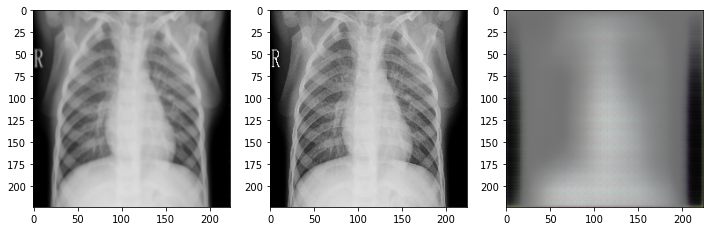

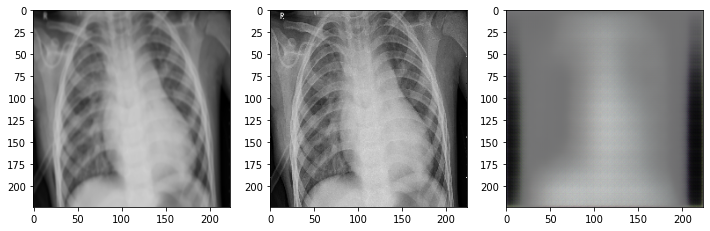

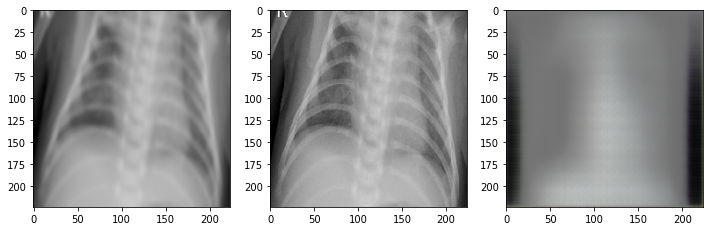

In [ ]:
print("\n       Input                        Ground Truth                  Predicted Value")
for i in range(3):
    
    r = random.randint(0, len(clean_frames)-1)

    x, y = blurry_frames[r],clean_frames[r]
    x_inp=x.reshape(1,224,224,3)
    result = autoencoder.predict(x_inp)
    result = result.reshape(224,224,3)

    fig = plt.figure(figsize=(12,10))
    fig.subplots_adjust(hspace=0.1, wspace=0.2)

    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x)

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(y)

    ax = fig.add_subplot(1, 3, 3)
    plt.imshow(result)

In [ ]:
from keras.models import load_model

# load model
model = load_model('/content/drive/MyDrive/idb/DAE5.h5')


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# ... rest of your code ...

# Evaluate model on test set
y_pred = model.predict(x_test)

# Calculate PSNR and SSIM
psnr_list = []
ssim_list = []
for i in range(len(x_test)):
    psnr_val = psnr(x_test[i], y_pred[i], data_range=1.0)
    ssim_val = ssim(x_test[i], y_pred[i], data_range=1.0, multichannel=True)
    psnr_list.append(psnr_val)
    ssim_list.append(ssim_val)

# Print average PSNR and SSIM values
print("Average PSNR:", np.mean(psnr_list))
print("Average SSIM:", np.mean(ssim_list))


3/3 [==============================] - 9s 2s/step


<ipython-input-13-3d761918b674>:17: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_val = ssim(x_test[i], y_pred[i], data_range=1.0, multichannel=True)


Average PSNR: 16.39618435533253
Average SSIM: 0.4653409
